# Tokenizer

In [75]:
import os
import random 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Conv1D, Flatten, Dropout, Input, GlobalMaxPooling1D, concatenate

We use the Tokenizer from Keras to convert text to sequences of integers. Each unique word is assigned a unique integer index.

In [76]:
df = pd.read_csv('data.csv')

Review the code below for implementation details.

In [77]:
def quit_space(text):
    text = text.lower()
    text = text.replace('\n', ' ')
    text = text.replace('\t', ' ')
    return text

# Split y Tokenizer
we use the Tokenizer from Keras to convert text to sequences of integers. Each unique word is assigned a unique integer index.

In [78]:
from sklearn.model_selection import train_test_split

df['Code1'] = df['Code1'].apply(quit_space)
df['Code2'] = df['Code2'].apply(quit_space)

x_features = df[['Code1', 'Code2']]
y_labels = df['Plagio']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x_features, y_labels, test_size=0.2, random_state=42)

# Tokenización y padding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train['Code1'] + X_train['Code2'])

X_train_code1_sequences = tokenizer.texts_to_sequences(X_train['Code1'])
X_train_code2_sequences = tokenizer.texts_to_sequences(X_train['Code2'])
X_test_code1_sequences = tokenizer.texts_to_sequences(X_test['Code1'])
X_test_code2_sequences = tokenizer.texts_to_sequences(X_test['Code2'])

max_length = max(max(len(seq) for seq in X_train_code1_sequences), max(len(seq) for seq in X_train_code2_sequences))

X_train_code1_padded = pad_sequences(X_train_code1_sequences, maxlen=max_length, padding='post', truncating='post')
X_train_code2_padded = pad_sequences(X_train_code2_sequences, maxlen=max_length, padding='post', truncating='post')
X_test_code1_padded = pad_sequences(X_test_code1_sequences, maxlen=max_length, padding='post', truncating='post')
X_test_code2_padded = pad_sequences(X_test_code2_sequences, maxlen=max_length, padding='post', truncating='post')

print(max_length)


4711


# Defining the CNN model
We define our CNN and its respective layers.

In [79]:
!pip install imbalanced-learn

In [80]:
!pip install --upgrade scikit-learn
!pip install --upgrade imbalanced-learn


In [81]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Conv1D, GlobalMaxPooling1D, concatenate, Input, Masking

embedding_dim = 100
num_filters = 64
filter_sizes = [3, 4, 5]
dropout_rate = 0.5

input1 = Input(shape=(max_length,))
input2 = Input(shape=(max_length,))

embedding_layer = Embedding(len(tokenizer.word_index) + 1, embedding_dim)

embedded_input1 = embedding_layer(input1)
embedded_input2 = embedding_layer(input2)

# LOCOOOOOO
masked_input1 = Masking(mask_value=0)(embedded_input1)
masked_input2 = Masking(mask_value=0)(embedded_input2)

conv_blocks = []
for filter_size in filter_sizes:
    conv = Conv1D(filters=num_filters, kernel_size=filter_size, activation='relu')
    conv_block1 = conv(masked_input1)
    conv_block2 = conv(masked_input2)
    pool1 = GlobalMaxPooling1D()(conv_block1)
    pool2 = GlobalMaxPooling1D()(conv_block2)
    conv_blocks.extend([pool1, pool2])

if len(filter_sizes) > 1:
    merged = concatenate(conv_blocks)
else:
    merged = conv_blocks[0]

drop1 = Dropout(dropout_rate)(merged)  
dense1 = Dense(64, activation='relu')(drop1)
#drop2 = Dropout(dropout_rate)(dense1)  
output = Dense(1, activation='sigmoid')(dense1)

model = Model(inputs=[input1, input2], outputs=output)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])


history = model.fit([X_train_code1_padded, X_train_code2_padded], y_train, epochs=10, batch_size=40, validation_data=([X_test_code1_padded, X_test_code2_padded], y_test))


Epoch 1/10


c:\Users\e1000\anaconda3\lib\site-packages\keras\src\layers\layer.py:877: UserWarning: Layer 'conv1d_27' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\e1000\anaconda3\lib\site-packages\keras\src\layers\layer.py:877: UserWarning: Layer 'conv1d_28' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\e1000\anaconda3\lib\site-packages\keras\src\layers\layer.py:877: UserWarning: Layer 'conv1d_29' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - acc: 0.6607 - loss: 0.6296 - val_acc: 0.7596 - val_loss: 0.5459
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - acc: 0.7139 - loss: 0.5851 - val_acc: 0.7596 - val_loss: 0.5417
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - acc: 0.7236 - loss: 0.5546 - val_acc: 0.7596 - val_loss: 0.5382
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - acc: 0.7382 - loss: 0.5230 - val_acc: 0.7596 - val_loss: 0.5265
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - acc: 0.7414 - loss: 0.4731 - val_acc: 0.7760 - val_loss: 0.5223
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - acc: 0.7816 - loss: 0.4298 - val_acc: 0.7923 - val_loss: 0.5061
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - acc: 0.8296 - loss: 0.3644 - val_acc: 0.7869 - val_loss: 0.5028
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - acc: 0.8803 - loss: 0.2967 - val_acc: 0.7760 - val_loss: 0.5213
Epoch 9/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - acc: 0.9255 - loss: 0.2422 - va

Evaluamos nuestro modelo.

In [82]:
# Evaluat the model
loss, accuracy = model.evaluate([X_test_code1_padded, X_test_code2_padded], y_test)
print("Loss:", loss)
print("Accuracy:", accuracy)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step - acc: 0.7770 - loss: 0.5645
Loss: 0.5877448320388794
Accuracy: 0.7595628499984741


we evaluate our model

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 395ms/step
Matriz de Confusión:
[[118  21]
 [ 23  21]]


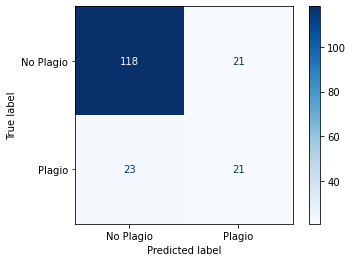

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Predictions and confusion matrix
y_pred = model.predict([X_test_code1_padded, X_test_code2_padded])
y_pred_classes = np.round(y_pred)

# Create the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

print("Confusion Matrix:")
print(conf_matrix)

disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['No Plagiarism', 'Plagiarism'])
disp.plot(cmap=plt.cm.Blues)
plt.show()


we evaluate our model.

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, f1_score, recall_score, accuracy_score, precision_score

# Convert predictions to binary labels
y_pred_test = (y_pred > 0.8).astype("int32")  # Para problemas binarios

# Calculate F1 and Recall
f1 = f1_score(y_test, y_pred_test, average='macro')
recall = recall_score(y_test, y_pred_test, average='macro')
accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test, average='macro')

# To obtain a detailed classification report
report = classification_report(y_test, y_pred_test)
print("Classification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.97      0.89       139
           1       0.79      0.34      0.48        44

    accuracy                           0.82       183
   macro avg       0.81      0.66      0.68       183
weighted avg       0.82      0.82      0.79       183



In [85]:
print("F1 Score Test: {:.2f}%".format(f1 * 100))
print("Recall Test: {:.2f}%".format(recall * 100))
print("Accuracy Test: {:.2f}%".format(accuracy * 100))
print("Precision Test: {:.2f}%".format(precision * 100))



F1 Score Test: 68.36%
Recall Test: 65.61%
Accuracy Test: 81.97%
Precision Test: 80.63%


We conduct tests with the test set.

In [ ]:
def es_plagio(code1, code2):
    # Preprocesing of the codes
    
    # Tokenización y padding
    code1_sequence = tokenizer.texts_to_sequences([code1])
    code2_sequence = tokenizer.texts_to_sequences([code2])
    
    code1_padded = pad_sequences(code1_sequence, maxlen=max_length, padding='post', truncating='post')
    code2_padded = pad_sequences(code2_sequence, maxlen=max_length, padding='post', truncating='post')

    # Model prediction
    plagiarism_prob = model.predict([code1_padded, code2_padded])
    print(plagiarism_prob)

    # If the plagiarism probability is high (e.g., greater than 0.5), it is considered plagiarism
    if plagiarism_prob > 0.2:
        return "Plagio detectado."
    else:
        return "No hay plagio."



In [ ]:
code1 = """
public class AreaTriangulo {

    public static void main(String[] args) {
        // Declaración de variables
        double base = 5.0;
        double altura = 3.0;
        double area;

        // Cálculo del área
        area = (base * altura) / 2;

        // Impresión del resultado
        System.out.println("El área del triángulo es: " + area);
    }
}"""

code2 = """ 
public class AreaTriangulo {

    public static void main(String[] args) {
        // Declaración de variables en orden inverso
        double altura = 3.0;
        double base = 5.0;
        double area;

        // Cálculo del área (mismo que el código 1)
        area = (base * altura) / 2;

        // Impresión del resultado (mismo que el código 1)
        System.out.println("El área del triángulo es: " + area);
    }
}"""

# Testing the plagiarism detection function
resultado = es_plagio(code1, code2)
print(resultado)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
[[0.53220534]]
Plagio detectado.
